Import cleaned data to start the EDA

In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
import numpy as np
#import warnings
#import mlflow
import matplotlib.pyplot as plt
#import rasterio
import geopandas as geopd
import rasterio.rio
import seaborn as sns
import datetime as dt 

from rasterio.plot import show

#import pyreadr



In [2]:
foxes_all = geopd.read_file("../data/cleaned_shapefiles/foxes_all.shp")
foxes_resamp = geopd.read_file("../data/cleaned_shapefiles/foxes_resamp.shp")
sample_points = geopd.read_file("../data/cleaned_shapefiles/sample_points.shp")
dens_all = geopd.read_file("../data/cleaned_shapefiles/dens_norrbotten.shp")

In [3]:
from datetime import datetime, timedelta
from shapely.geometry import Point
import geopandas as gpd
#import math

#import geopy.distance

''' 
Function to get an array of diffs in seconds between time stamps of subsequent rows of a DataFrame
'''

def get_time_diffs(df, df_time_col = "t_"):
    fmt = '%Y-%m-%d-%H:%M:%S'
    time_diff = []
   # travel_distance = []
    for i, fox in enumerate(df.t_):
        if i > 0 and df.iloc[i-1].id == df.iloc[i].id :
            time_1 = datetime.strptime(df.iloc[i-1][df_time_col], fmt)
            time_2 = datetime.strptime(df.iloc[i][df_time_col], fmt)
            time_diff.append((time_2 - time_1).total_seconds())
        else:
            time_diff.append(np.nan)
    return time_diff
    
def get_distance(df): 
  travel_distance = []
  for i, fox in enumerate(df.t_):
    if i > 0 and df.id.iloc[i-1] == df.id.iloc[i]:
      x_diff = df.x_.iloc[i-1] - df.x_.iloc[i]
      y_diff = df.y_.iloc[i-1] - df.y_.iloc[i]
      tot_diff = np.sqrt(np.square(x_diff) + np.square(y_diff) )
      travel_distance.append(tot_diff)
    else:
      travel_distance.append(np.nan)
  return travel_distance

foxes_all["travel_distance"] = get_distance(foxes_all)
foxes_all["time_diff"] = get_time_diffs(foxes_all)
 
#foxes_all.eval('travel_speed = (travel_distance / 1000 ) / (time_diff / 3600)', inplace = True)  




In [4]:
foxes_all["fox_day"] = [str(datetime.strptime(x, '%Y-%m-%d-%H:%M:%S' ) + timedelta(hours=12))[:10]  for x in foxes_all.t_ ]
foxes_all["month"] = [x[5:7] for x in foxes_all.fox_day]
foxes_all["year"] = [x[:4] for x in foxes_all.fox_day]
foxes_all.info()

factor = 100
foxes_all["geo_round"] = [(int(x/factor) * factor + factor / 2, int(y/factor)  * factor + factor / 2) for x, y in zip(foxes_all.x_, foxes_all.y_) ]


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50133 entries, 0 to 50132
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   x_               50133 non-null  float64 
 1   y_               50133 non-null  float64 
 2   t_               50133 non-null  object  
 3   id               50133 non-null  object  
 4   sex              50133 non-null  object  
 5   NDVI             50133 non-null  float64 
 6   NDMI             50133 non-null  float64 
 7   soil             50133 non-null  object  
 8   veg              50133 non-null  object  
 9   slope            50133 non-null  float64 
 10  aspect           50133 non-null  float64 
 11  elev             50133 non-null  float64 
 12  timestamp        50133 non-null  float64 
 13  geometry         50133 non-null  geometry
 14  travel_distance  50121 non-null  float64 
 15  time_diff        50121 non-null  float64 
 16  fox_day          50133 non-null 

In [5]:
d = foxes_all.geometry
gdf = gpd.GeoDataFrame(d, crs=3006)


gdf = gdf.to_crs(epsg= 4326)

foxes_all["geo_kepler_lat"] = [geo.y for geo in gdf.geometry]
foxes_all["geo_kepler_lon"] = [geo.x for geo in gdf.geometry]

foxes_all

points_per_day = foxes_all[["id", "time_diff", "fox_day"]].groupby(["id","fox_day"], as_index=False ).count().rename(columns={"time_diff": "points_this_day"})

max_window_per_day = foxes_all[["id", "time_diff", "fox_day"]].groupby(["id","fox_day"], as_index=False ).max().rename(columns={"time_diff": "max_window"})

a = pd.merge( foxes_all,points_per_day, left_on=["id", "fox_day"], right_on=["id", "fox_day"] )
b = pd.merge( max_window_per_day, a , left_on=["id", "fox_day"], right_on=["id", "fox_day"] )
#b[["id", "fox_day", "t_", "time_diff", "points_this_day", "max_window"]]




In [6]:
def polygon_to_geojson(poly):
    poly_coords = poly.boundary.coords.xy
    
    s= pd.DataFrame( [Point(x,y) for x,y in zip( poly_coords[0], poly_coords[1])])
    s.columns = ["geometry"]
   # print(type(s))
    gdf = gpd.GeoDataFrame(s, crs=3006)
    gdf = gdf.to_crs(epsg= 4326)
 #   print(type(gdf))
 #   print(gdf)
  #  print(len(gdf))
    geojson = {'type':'Polygon', 'coordinates':[]}
    f  = []
    for point in gdf.geometry:
   #     print("huh")
       #print(point.x, point.y)
        f.append([point.x, point.y])
    geojson['coordinates'].append(f)
    return geojson

def dataframe_convert_coords(df, coord_in = 3006, coord_out = 4326):
    gdf = gpd.GeoDataFrame(df, crs=coord_in)
    return gdf.to_crs(epsg= coord_out)


def max_dist_point_poly(point, poly):
    max_dist = 0
    poly_coords = poly.boundary.coords.xy
    for point_poly in [Point(x,y) for x,y in zip( poly_coords[0], poly_coords[1])]:
        if point.distance(point_poly) > max_dist:
            max_dist = point.distance(point_poly)
    return max_dist

def df_to_geojson_trip(df, properties, lat='geo_kepler_lat', lon='geo_kepler_lon', elev = 'elev', time = 'timestamp', id = 'id'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for fox_id in df[id].unique():
        i =0
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'LineString',
                               'coordinates':[]}}
        for _, row in df.query('id == @fox_id').iterrows():        
       #     feature['geometry']['coordinates'].append([row[lon], row[lat], row[elev],  int(row[time])])
            feature['geometry']['coordinates'].append([row[lon], row[lat], row[elev], 1564184363 + 10 * i])# row[time]])
            i += 1
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson


In [7]:
import sys
sys.path.append("../modeling")
import home_ranges as hr

from keplergl import KeplerGl
#map1=KeplerGl(height=500)



In [8]:

for fox_id in foxes_all.id.unique():
    fox_hr_poly = hr.hr_area(foxes_all.query('id ==@fox_id'))


In [9]:
#x = pd.DataFrame(columns=["a", "b", "c"])

y = foxes_all.groupby(["id", "sex"], as_index=False).count()[["id","sex"]]

#for z in y.id:
 #   print(z)
#y["geometry"] = [polygon_to_geojson(hr.hr_area(foxes_all.query('id ==@x'))) for x in y.id ]
y["hr_area"] = [hr.hr_area(foxes_all.query('id ==@x')).area for x in y.id ]
#y.describe()


In [10]:
y.hr_area.min() / y.hr_area.max()

0.12282918902015916

In [11]:
foxes_all

,x_,y_,t_,id,sex,NDVI,NDMI,soil,veg,slope,...,timestamp,geometry,travel_distance,time_diff,fox_day,month,year,geo_round,geo_kepler_lat,geo_kepler_lon
0,548522.717454,7.353167e+06,2018-07-10-01:56:30,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,...,1.531181e+09,POINT (548522.717 7353166.639),NaN,NaN,2018-07-10,07,2018,"(548550.0, 7353150.0)",66.294597,16.081633
1,548525.680513,7.353168e+06,2018-07-10-06:56:32,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,...,1.531199e+09,POINT (548525.681 7353168.363),3.427867,18002.0,2018-07-10,07,2018,"(548550.0, 7353150.0)",66.294612,16.081700
2,548539.963810,7.353164e+06,2018-07-10-11:56:32,2018-FSBD608-001,F,0.662722,0.125608,Moraine,Dry Shrub,10.135784,...,1.531217e+09,POINT (548539.964 7353164.150),14.891535,18000.0,2018-07-10,07,2018,"(548550.0, 7353150.0)",66.294572,16.082017
3,548195.507163,7.352493e+06,2018-07-10-22:31:11,2018-FSBD608-001,F,0.443307,-0.138425,Stone,Grassland,10.065748,...,1.531255e+09,POINT (548195.507 7352493.197),754.207680,38079.0,2018-07-11,07,2018,"(548150.0, 7352450.0)",66.288607,16.074083
4,548558.891944,7.352589e+06,2018-07-11-13:31:01,2018-FSBD608-001,F,0.504280,-0.113833,Stone,Grassland,12.232175,...,1.531309e+09,POINT (548558.892 7352588.648),375.711810,53990.0,2018-07-12,07,2018,"(548550.0, 7352550.0)",66.289407,16.082217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50128,543632.466003,7.379183e+06,2019-12-14-08:10:19,2019-FSBD641_y-gr/r-b,M,0.386280,-0.137583,Stone,Stone,6.499063,...,1.576307e+09,POINT (543632.466 7379183.144),9449.328321,14405.0,2019-12-14,12,2019,"(543650.0, 7379150.0)",66.528680,15.981750
50129,544607.109028,7.378558e+06,2019-12-14-12:10:15,2019-FSBD641_y-gr/r-b,M,0.248821,-0.214249,Roesberg,Dry Shrub,11.062690,...,1.576322e+09,POINT (544607.109 7378558.328),1157.723289,14396.0,2019-12-15,12,2019,"(544650.0, 7378550.0)",66.522937,16.003450
50130,544147.656802,7.379631e+06,2019-12-14-16:10:13,2019-FSBD641_y-gr/r-b,M,0.000000,-1.000000,Stone,Dry Shrub,14.816979,...,1.576336e+09,POINT (544147.657 7379630.549),1166.513787,14398.0,2019-12-15,12,2019,"(544150.0, 7379650.0)",66.532620,15.993500
50131,539474.780875,7.379241e+06,2019-12-15-00:10:14,2019-FSBD641_y-gr/r-b,M,0.000000,-1.000000,Stone,Stone,18.056763,...,1.576365e+09,POINT (539474.781 7379241.118),4689.075177,28801.0,2019-12-15,12,2019,"(539450.0, 7379250.0)",66.529758,15.888233


In [12]:

#from IPython.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

#fox_id = "2019-FSBD641_y-gr/r-b"
from shapely.geometry import Polygon
circle_all = Polygon()
hr_all = Polygon()
intersect_all = Polygon()
map1=KeplerGl(height=500)

cols_df = ["id", "geo_kepler_lat", "geo_kepler_lon"]


#map1.add_data(data = dens_all, name="dens") 
for fox_id in foxes_all.query("id == '2019-FSBD609-002'").id.unique():    
    fox_hr_poly = hr.hr_area(foxes_all.query('id ==@fox_id'))
  #  den = foxes_all.query('id ==@fox_id')[["id", "geo_round", "t_"]].groupby(["id", "geo_round"], as_index=False).count().sort_values(by="t_").tail(1).geo_round 
    #den_coord = Point(tuple(den)[0][0] , tuple(den)[0][1] )
    #circle = den_coord.buffer(max_dist_point_poly(den_coord, fox_hr_poly))
  #  x = hr_all.intersection(fox_hr_poly)
   # intersect_all = intersect_all.union(x)
   # circle_all = circle_all.union(circle)
    #hr_all = hr_all.union(fox_hr_poly)
    cols = ['fox_day']
    geojson = df_to_geojson_trip(foxes_all.query('id ==@fox_id'), cols)
    map1.add_data(data= foxes_all.query("id == @fox_id ")[cols_df], name = "where did the fox go")
    map1.add_data(data=geojson,name='Where does fox  ' + fox_id + ' trot?')
    
    #map1.add_data(data=g(den_coord, columns="geometry"), name = "center" + fox_id)
    map1.add_data(data = polygon_to_geojson(fox_hr_poly), name='homerange' + fox_id)
    #map1.add_data(data = polygon_to_geojson(circle), name="circle" + fox_id)


map1



User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'where did the fox go': {'index': [23415, 23416, 23417, 23418, 23419, 23420, 23421, 23422, 2342…

In [13]:
foxes_all.astype({'geometry': 'geometry'}).info() #.id.value_counts()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 50133 entries, 0 to 50132
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   x_               50133 non-null  float64 
 1   y_               50133 non-null  float64 
 2   t_               50133 non-null  object  
 3   id               50133 non-null  object  
 4   sex              50133 non-null  object  
 5   NDVI             50133 non-null  float64 
 6   NDMI             50133 non-null  float64 
 7   soil             50133 non-null  object  
 8   veg              50133 non-null  object  
 9   slope            50133 non-null  float64 
 10  aspect           50133 non-null  float64 
 11  elev             50133 non-null  float64 
 12  timestamp        50133 non-null  float64 
 13  geometry         50133 non-null  geometry
 14  travel_distance  50121 non-null  float64 
 15  time_diff        50121 non-null  float64 
 16  fox_day          50133 non-null 

In [14]:
dens_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 464 entries, 0 to 463
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Ly_nr_    464 non-null    object  
 1   Namn      463 non-null    object  
 2   Fjllmrd   456 non-null    object  
 3   geometry  464 non-null    geometry
dtypes: geometry(1), object(3)
memory usage: 14.6+ KB


[]

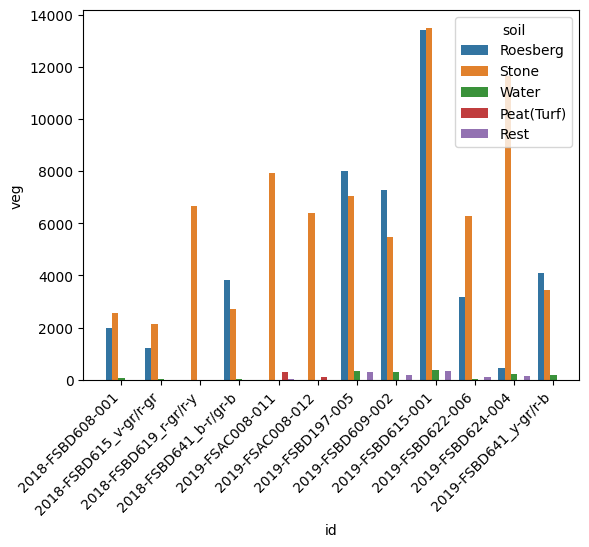

In [15]:
sample_points_by_hr_with_id = pd.DataFrame(columns=["geometry", "id"])

for fox_id in foxes_all.id.unique():
    points = sample_points.intersection(hr.hr_area(foxes_all.query('id ==@fox_id')))
    df_temp = pd.DataFrame(columns=["geometry"], data=points[~points.is_empty].to_list())
    df_temp["id"] = fox_id
    sample_points_by_hr_with_id = pd.concat([sample_points_by_hr_with_id, df_temp ])

sample_points_in_hr_with_id = sample_points_by_hr_with_id.drop_duplicates().merge(sample_points, on = "geometry")

a = sample_points_in_hr_with_id[["id", "soil", "veg"]].groupby(["id", "veg"], as_index=False).count()
b = sample_points_in_hr_with_id[["id", "soil", "veg"]].replace("Moraine", "Stone").groupby(["id", "soil"], as_index=False).count()

chart_soil = sns.barplot(data = b[["id", "soil", "veg"]], x="id", y="veg", hue="soil")
chart_soil.set_xticklabels(chart_soil.get_xticklabels(), rotation=45, horizontalalignment='right')
chart_soil.plot()

[]

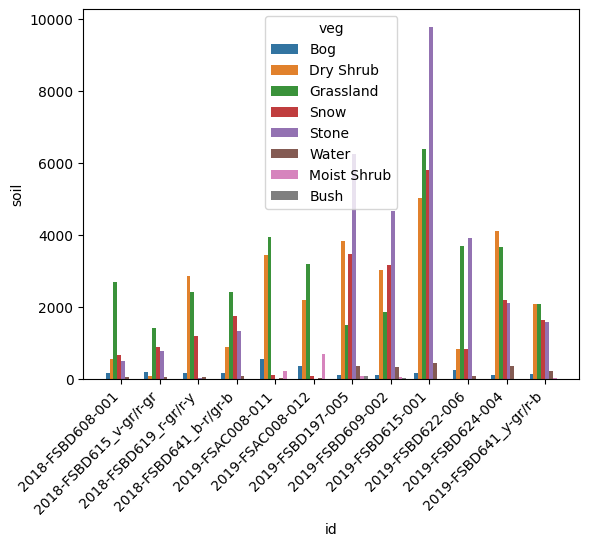

In [16]:
chart_veg = sns.barplot(data = a[["id", "soil", "veg"]], x="id", y="soil", hue="veg")
chart_veg.set_xticklabels(chart_veg.get_xticklabels(), rotation=45, horizontalalignment='right')
chart_veg.plot()